In [ ]:
pip install -r requirements.txt

In [99]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor

########### mflow ############
import mlflow
import mlflow.sklearn
########### mflow ############

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

from sharelib import *
import logging
from pathlib import Path
import json
import glob
import sys
import pickle

logging.basicConfig(level=logging.WARN)
logger = logging.getLogger(__name__)

jenkinsURL = getArgs(1,"")
mlflowMinioFolder = getArgs(2,"")
mlflowTrainingFileLimit = int(getArgs(13,10))

# print(mlflowTrainingFileLimit)

In [100]:
if __name__ == "__main__":
    df = pd.DataFrame()
    path_to_json = 'rawdata6' 
    # json_pattern = os.path.join(path_to_json,'ls.s3.0af212df-82c8-4149-b1d7-067dfac00e4a.2023-10-10T03.20.part124.txt')
    json_pattern = os.path.join(path_to_json,'*.txt')
    file_list = glob.glob(json_pattern)
    
    xcount = 0

    for file in file_list:
        xcount = xcount + 1
        print("xcount: ", xcount)
        data = pd.read_json(file, lines=True)
        df = pd.concat([df,data], ignore_index = True)
        if (xcount == mlflowTrainingFileLimit):
            break

xcount:  1
xcount:  2
xcount:  3
xcount:  4
xcount:  5
xcount:  6
xcount:  7
xcount:  8
xcount:  9
xcount:  10


In [101]:
    np.set_printoptions(threshold=sys.maxsize)
    
    df_categories = pd.concat([df["ads_ts_hh"]], axis=1, sort=False,)
    print("-------------- Count Record --------------")
    print(df_categories.shape[0])
    print("-------------- Count Record --------------")
    print("-------------- Count HH --------------")
    print(df_categories.value_counts().to_string())
    print("-------------- Count HH --------------")

    X = df_categories
    print("-------------- X --------------")
    print(X.value_counts().to_string())
    print("-------------- X --------------")


-------------- Count Record --------------
1614
-------------- Count Record --------------
-------------- Count HH --------------
ads_ts_hh
15           544
8            427
13           352
12           205
23            31
4             23
21            23
3              9
-------------- Count HH --------------
-------------- X --------------
ads_ts_hh
15           544
8            427
13           352
12           205
23            31
4             23
21            23
3              9
-------------- X --------------


In [151]:
# Call and fit the Local Outlier Factor detector
lof_detector = LocalOutlierFactor(n_neighbors=100, contamination=0.1,novelty=True).fit(X.values)

print("-------------- Model Size (MB) --------------")
print("{:.2f}".format(sys.getsizeof(pickle.dumps(lof_detector))/(1024*1024)))
print("-------------- Model Size (MB) --------------")

lof_detect = lof_detector.predict(X)

-------------- Model Size (MB) --------------
1.30
-------------- Model Size (MB) --------------


In [152]:
recordDetect,countDetect = np.unique(lof_detect, return_counts=True)
print("--------------Count Anomaly VS Normal-------------")
print(recordDetect)
print(countDetect)

if (len(countDetect) == 1):
    row_to_be_added = countDetect
    countDetect = np.append(np.array([0]),row_to_be_added,axis=0)

print("Anomaly = " , countDetect[0] , "record with " , (countDetect[0])*100/(countDetect[0]+countDetect[1]) ," %")
print("Normal  = " , countDetect[1] , "record with " , (countDetect[1])*100/(countDetect[0]+countDetect[1]) ," %")
print("--------------Count Anomaly VS Normal-------------")
# print(lof_detect)

--------------Count Anomaly VS Normal-------------
[-1  1]
[  86 1528]
Anomaly =  86 record with  5.328376703841388  %
Normal  =  1528 record with  94.67162329615861  %
--------------Count Anomaly VS Normal-------------


In [153]:
np.set_printoptions(formatter={'float_kind':'{:f}'.format})
print(np.unique(lof_detector.negative_outlier_factor_, return_counts=True))
print(lof_detector.negative_outlier_factor_)


(array([-35438000001.031960, -32913000001.038231, -31114000000.962177,
       -28221000000.987167, -1.000000]), array([  31,    9,   23,   23, 1528], dtype=int64))
[-31114000000.962177 -31114000000.962177 -31114000000.962177
 -31114000000.962177 -31114000000.962177 -31114000000.962177
 -31114000000.962177 -31114000000.962177 -31114000000.962177
 -31114000000.962177 -31114000000.962177 -31114000000.962177
 -31114000000.962177 -31114000000.962177 -31114000000.962177
 -31114000000.962177 -31114000000.962177 -31114000000.962177
 -31114000000.962177 -31114000000.962177 -31114000000.962177
 -31114000000.962177 -31114000000.962177 -28221000000.987167
 -28221000000.987167 -28221000000.987167 -28221000000.987167
 -28221000000.987167 -28221000000.987167 -28221000000.987167
 -28221000000.987167 -28221000000.987167 -28221000000.987167
 -28221000000.987167 -28221000000.987167 -28221000000.987167
 -28221000000.987167 -28221000000.987167 -28221000000.987167
 -28221000000.987167 -28221000000.987167 -2

In [154]:
print("-------------- List HH with Prediction -------------")
for index, value in df_categories.value_counts().items():
    tempdf = pd.DataFrame([
        [index[0]]
    ], columns=['ads_ts_hh'])
    predictData = lof_detector.predict(tempdf)
    print(index[0]  , " | count ="  , value , " | result =" , dataPredictionToString(predictData[0]))

print("-------------- List HH with Prediction -------------")

-------------- List HH with Prediction -------------
15  | count = 544  | result = Normally
8  | count = 427  | result = Normally
13  | count = 352  | result = Normally
12  | count = 205  | result = Normally
23  | count = 31  | result = Anomaly
4  | count = 23  | result = Anomaly
21  | count = 23  | result = Anomaly
3  | count = 9  | result = Anomaly
-------------- List HH with Prediction -------------


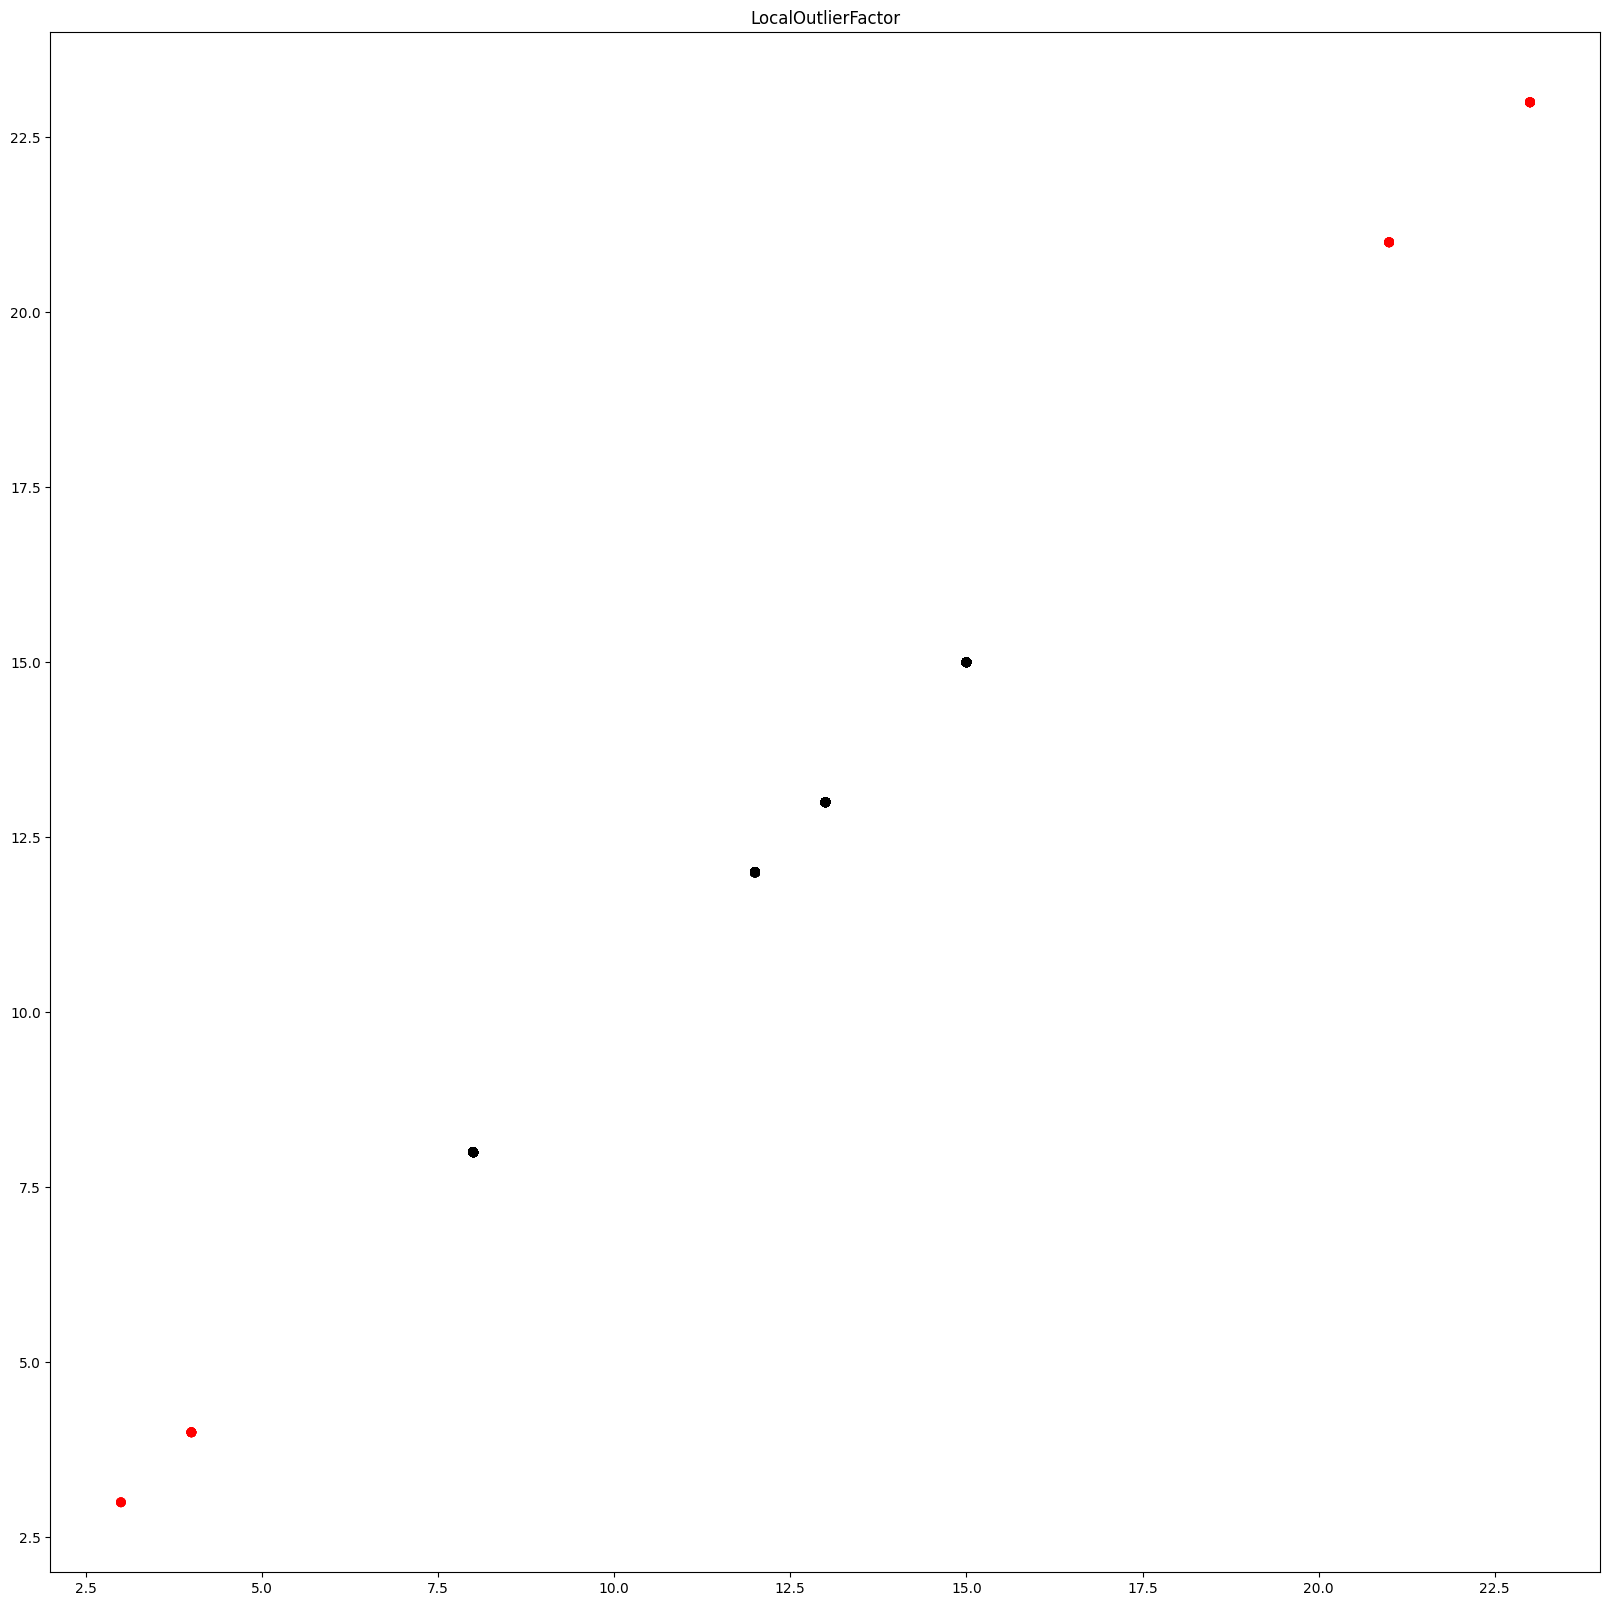

In [155]:
plt.figure(figsize=(20,20))
plt.scatter(X.to_numpy()[:, 0], X.to_numpy()[:, 0], c=lof_detect, cmap="flag", alpha=0.5)
plt.title("LocalOutlierFactor")
plt.show()

In [156]:
# %set_env MLFLOW_TRACKING_URI=http://127.0.0.1:5000
%set_env MLFLOW_TRACKING_URI=http://mlflow.rtarf-ml.its-software-services.com/
tracking_uri = os.environ["MLFLOW_TRACKING_URI"]
# export MLFLOW_TRACKING_USERNAME=user 
# export MLFLOW_TRACKING_PASSWORD=pwd

experiment = mlflow.set_experiment(experiment_name='ads-anomaly-time')
experiment_id = experiment.experiment_id

run_description = f"""
### Note
**All information** * about Training * ~~ML here~~ .
Jenkins URL: [{jenkinsURL}]({jenkinsURL})
"""

with mlflow.start_run(experiment_id=experiment_id,description=run_description):
    mlflow.set_tracking_uri(tracking_uri)
    
    print("Artifact Location: {}".format(experiment.artifact_location))
    print("artifact uri : " + mlflow.get_artifact_uri())

    mlflow.doctor()
    mlflow.log_param("MlflowMinioFolder", mlflowMinioFolder)
    mlflow.log_param("SampleFile", xcount)
    mlflow.log_param("SampleRows", X.shape[0])
    # mlflow.set_tag("JenkinsURL",jenkinsURL)

    mlflow.log_metric("Anomaly", str((countDetect[0])*100/(countDetect[0]+countDetect[1])))
    mlflow.log_metric("Normal", str((countDetect[1])*100/(countDetect[0]+countDetect[1])))
    mlflow.sklearn.log_model(lof_detector, "model", registered_model_name="ads-anomaly-by-time")
    print("Model saved in run %s" % mlflow.active_run().info.run_uuid)

env: MLFLOW_TRACKING_URI=http://mlflow.rtarf-ml.its-software-services.com/
Artifact Location: mlflow-artifacts:/5
artifact uri : mlflow-artifacts:/5/61290a6d99c145d096b804b998ef99b2/artifacts
System information: Windows 10.0.19045
Python version: 3.9.7
MLflow version: 2.1.1
MLflow module location: C:\Users\sutee.k\AppData\Roaming\Python\Python39\site-packages\mlflow\__init__.py
Tracking URI: http://mlflow.rtarf-ml.its-software-services.com/
Registry URI: http://mlflow.rtarf-ml.its-software-services.com/
Active experiment ID: 5
Active run ID: 61290a6d99c145d096b804b998ef99b2
Active run artifact URI: mlflow-artifacts:/5/61290a6d99c145d096b804b998ef99b2/artifacts
MLflow environment variables: 
  MLFLOW_TRACKING_URI: http://mlflow.rtarf-ml.its-software-services.com/
MLflow dependencies: 
  Flask: 2.3.3
  Jinja2: 3.1.2
  alembic: 1.12.0
  click: 8.1.7
  cloudpickle: 2.2.1
  databricks-cli: 0.17.8
  docker: 6.1.3
  entrypoints: 0.4
  gitpython: 3.1.37
  importlib-metadata: 5.2.0
  markdown: 

Registered model 'ads-anomaly-by-time' already exists. Creating a new version of this model...
2023/10/15 17:53:34 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: ads-anomaly-by-time, version 2


Model saved in run 61290a6d99c145d096b804b998ef99b2


Created version '2' of model 'ads-anomaly-by-time'.


In [10]:
!mlflow models serve -m mlflow-artifacts:/394149324160139362/f188152b48494d1c86de6a4f8397908d/artifacts/model -p 1234 --no-conda

^C


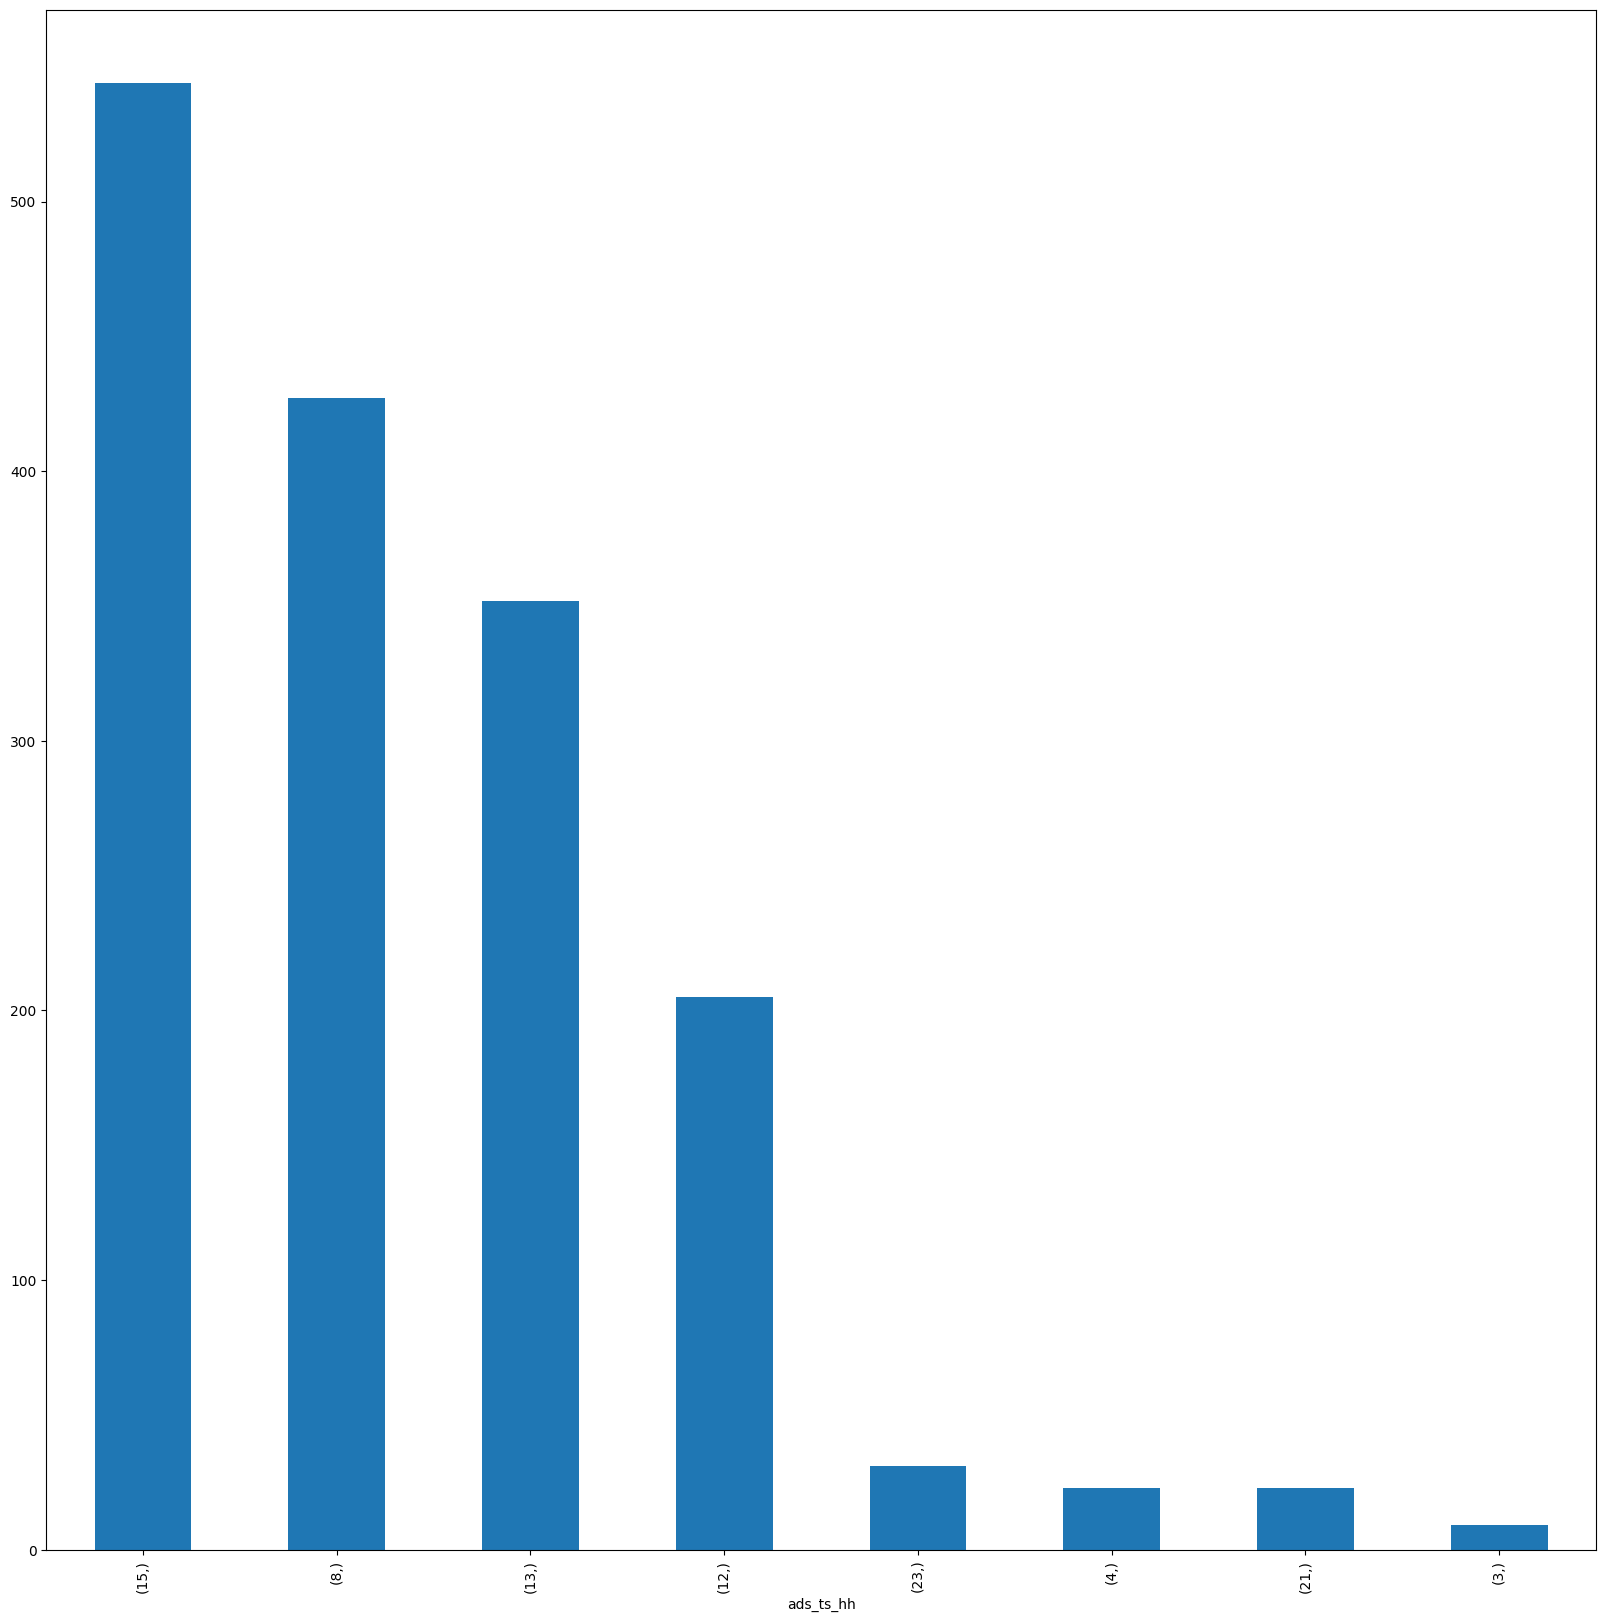

In [157]:
# Plot the conparison between actual and predicted y
df_categories.value_counts()[: :].plot(kind="bar", figsize=(20,20))
plt.show()